# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [120]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import datetime
import sympy as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from arch import arch_model
from ipywidgets import HBox, VBox, Dropdown, Output
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
from scipy import optimize
from IPython.display import display

plt.style.use('seaborn-whitegrid')
pd.set_option("display.precision", 5)

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# You may need to install the following packeges (delete #):
#!pip install plotly
#!pip install arch

# Model description

We examine the time-varying co-movements and portfolio diversification between Danish and German stock markets employing the symmetric conditional correlation multivariate GARCH models and following the minimum variance portfolio approach. We use daily return data for C20 and DAX30 indices for the period 2000 to 2021. This study finds a useful combination of Danish and German stock markets for construction of a portfolio in order to minimize the risk.

## Analytical solution

$$\begin{aligned}
y_t=\mu+\epsilon_t 
\end{aligned}$$


$$\begin{aligned}
\epsilon_t=\sigma_t z_t 
\end{aligned}$$


$$\begin{aligned}
\sigma_t^2={\omega }+\alpha\epsilon_{t-1}^2+\beta\sigma_{t-1}^2
\end{aligned}
$$

with initial values $\epsilon_0$ and $\sigma_0^2$. $y_t$ is log return of an asset at time t, $\mu$ is the expected value of the conditional $y_t$, $\epsilon_t$ is a error at time t, which can be considered as mean-corrected return of an asset at time t, $z_t$ is an independent and identically distributed error term with mean zero, and unit variance, and $\sigma_t^2$ is the conditional variance at time t, conditioned on the history available at the beginning of period t. 

The conditional variance, $\sigma_t^2$ varies over time. This observation is a stylized fact of the behavior of financial time series that large (small) changes of any sign tend to be followed by large (small) changes.

For the GARCH model to be well defined and the conditional variance to be positive, parameters need to satisfy the following conditions: ${\omega }>0$, $\alpha \geq 0$ and $\beta \geq 0$. To ensure covariance stationarity, condition $\alpha+\beta<1$ must hold.

The multivariate GARCH models can be defined by the following equations:
$$\begin{aligned}
y_t=\mu+\epsilon_t 
\end{aligned}$$

$$\begin{aligned}
\epsilon_t=H_t^{1/2} z_t
\end{aligned}$$

where $y_t$ is a N x 1 stochastic vector process. $\mu$ is N x 1 vector of the expected value of the conditional $y_t$, $\epsilon_t$ is N x 1 vector of errors at time t, $z_t$ is i.i.d. with mean 0 and $E[z_tz_t^T]=I$. $H_t$ is the N x N matrix of the conditional covariance of $\epsilon_t$ at time t. The vector of the errors can be seen as mean-corrected returns of the assets at time t with $E[\epsilon_t]=0$ and $Cov[\epsilon_t]=H_t$. What remains to be specified is the matrix process $H_t$.
$H_t^{1/2}$ means the symmetric matrix square root, such that $H_t^{1/2}H_t^{1/2}=H_t$. 

Correlation models are based on the decomposition of the conditional covariance matrix into conditional standard deviation and correlations. 
Having returns, $y_t$, from N assets with expected value 0 and covariance matrix $H_t$,
the DCC-GARCH model can be defined as:
$$\begin{aligned}
H_t=D_tP_tD_t
\end{aligned}$$

where $D_t$ = diag($\sigma_{1,t}, ..., \sigma_{N,t}$) is conditional standard deviation and $P_t=[\rho_{ij}]$ is positive definite correlation matrix with $\rho_{ii}=1$ ($i,j=1, ..., N$). The off-diagonal elements of the conditional covariance matrix are defined as follows $[H_t]_{ij}$=$\sigma_{i,t}\sigma_{j,t}\rho_{ij}$, $i\neq j$ ($i,j=1, ..., N$).
$P_t$ is a time-varying correlation matrix of the standardized errors, $\epsilon_t$.

## Numerical solution

### Dynamic Conditional Correlation GARCH model

In [122]:
model_parameters = {}
udata_list = []

def run_garch_on_return(rets, udata_list, model_parameters):
    for x in rets:
        am = arch_model(rets[x], dist = 't')
        short_name = x.split()[0]
        model_parameters[short_name] = am.fit(disp='off')
        udata = mp.garch_t_to_u(rets[x], model_parameters[short_name])
        udata_list.append(udata)
    return udata_list, model_parameters

In [123]:
# In order to estimate our model, we either need download data or simulate a data.
# We download Excel file with data using Pandas

df = pd.read_excel('D.xlsx')
df.drop(columns='Unnamed: 0', inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date',inplace = True) 

In [124]:
udata_list, model_parameters = run_garch_on_return(df.loc[:,'DDAX30':'DC20'].dropna(), udata_list, model_parameters)

In [125]:
# Descriptive statistic
df.loc[:,'DDAX30':'DC20'].dropna().corr() #unconditional correlation

DDAX30     DC20
DDAX30  1.00000  0.61016
DC20    0.61016  1.00000

In [126]:
# First difference of log daily data
df.loc[:,'DDAX30':'DC20'].describe()

DDAX30        DC20
count  5427.00000  5427.00000
mean      0.01401     0.03140
std       1.48378     1.25768
min     -13.05486   -11.72319
25%      -0.66006    -0.59107
50%       0.06539     0.05674
75%       0.73933     0.69672
max      10.79747     9.49635

In [127]:
# Constrains for our model
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.5), (0, 0.9997))

In [128]:
%time opt_out = minimize(mp.loglike_norm_dcc_copula, [0.01, 0.95], args = (udata_list,), bounds=bnds, constraints=cons)

CPU times: user 56.4 s, sys: 561 ms, total: 56.9 s
Wall time: 16.6 s


In [129]:
print(opt_out.success)
print(opt_out.x) #GARCH parameters

True
[0.03815038 0.94536462]


In [130]:
# Log likelihood 
llf  = mp.loglike_norm_dcc_copula(opt_out.x, udata_list)
llf

-1213.1373941853103

In [131]:
# Distribution
trdata = np.array(norm.ppf(udata_list).T, ndmin=2)
Rt, veclRt = mp.dcceq(opt_out.x, trdata)

In [132]:
# Creating a list of stocks and correlation pairs.
corr_name_list = ['DAX30 - C20']
stock_names = ['DDAX30','DC20']

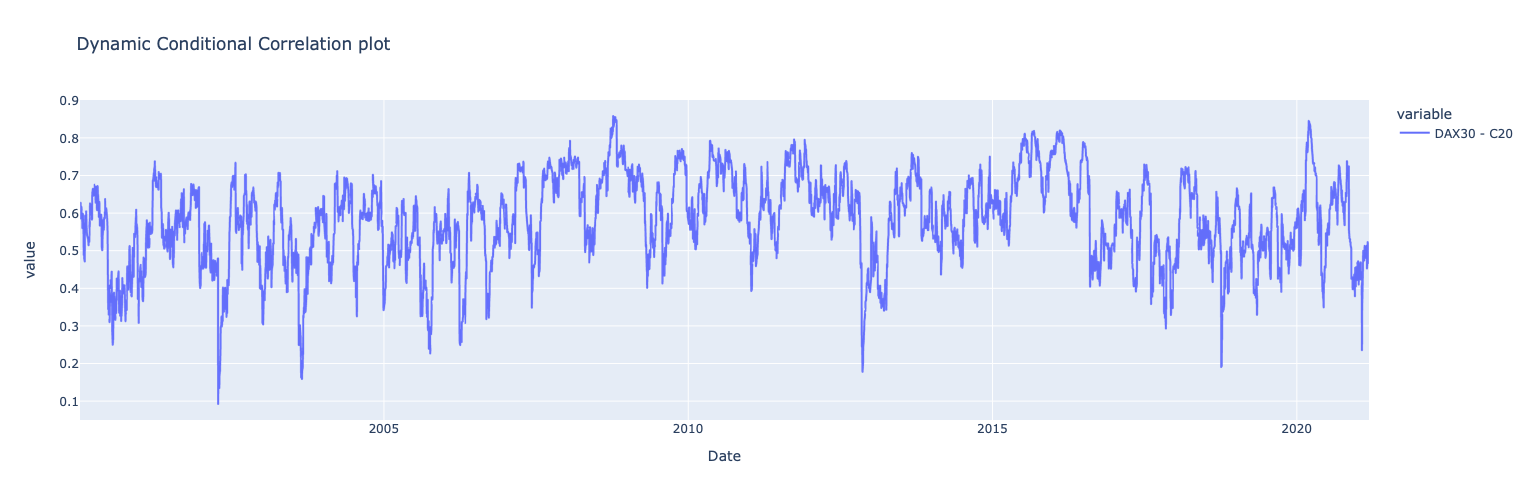

In [133]:
#Plotting Dynamic Conditional Correlation (parameter rho):
dcc_corr = pd.DataFrame(veclRt, index = df.loc[:,'DDAX30':'DC20'].dropna().index, columns= corr_name_list)
dcc_plot = px.line(dcc_corr, title = 'Dynamic Conditional Correlation plot', width=1000, height=500)
dcc_plot.show()

From the upper part of Figure 2 we can see that correlation was lower in period before the Financial Crises and the following recession (before 2008) and in period between after the Financial Crises and the following recession (after 2016), and before the current crisis. We can also see that in periods of severe crises, such as Financial Crisis in 2009 and uncertainty caused by Covid-19 in March - April 2020, correlation between Danish and German stock markets was very high. In these periods adding of DAX30 index into a portfolio would not help a lot in order to minimize the risk. In other periods, such as in 2002, 2013 and 2019, correlation between Danish and German stock markets was lowest, and, therefore, diversification's potential could be high. We note that correlations are changing over time, then the benefits of diversification will be changing as well.

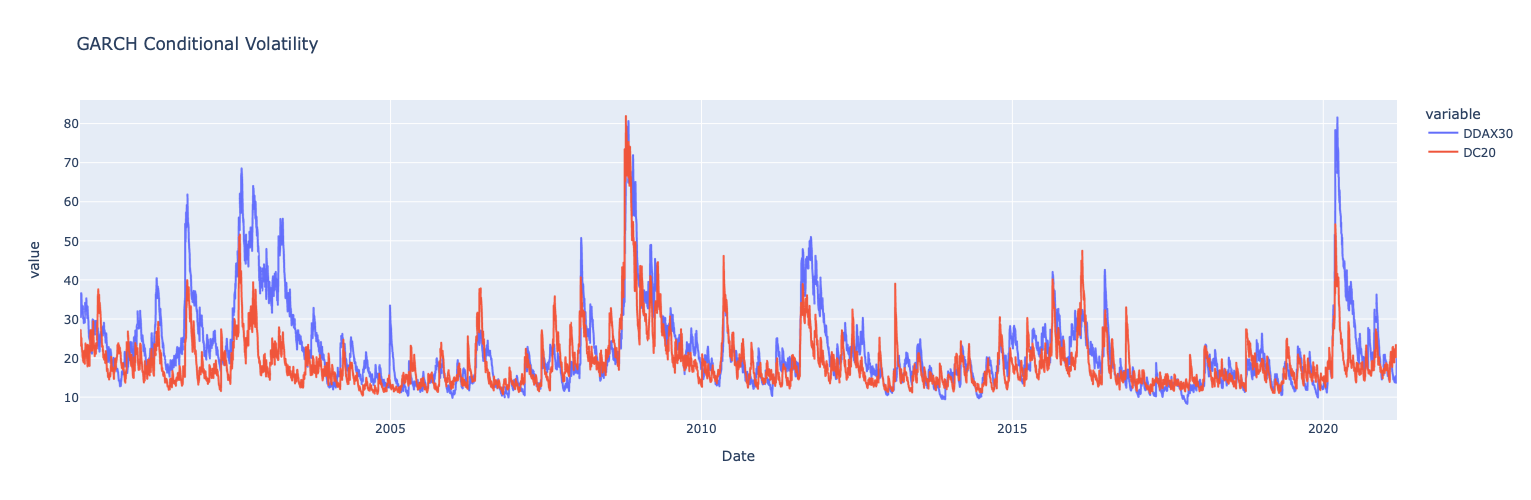

In [134]:
# Calculatiog and plotting GARCH Conditional Volatility for both time series;
garch_vol_df = pd.concat([pd.DataFrame(model_parameters[x].conditional_volatility/100)*1600 for x in model_parameters], axis=1)
garch_vol_df.columns = stock_names
px.line(garch_vol_df, title='GARCH Conditional Volatility', width=1000, height=500).show()

The figure above presents a graphical representation of the estimated values of conditional variances of both stock markets using the DCC-GARCH model. The values plotted in the figure show the time-varying nature of volatilities. We can see that in some periods graphs share movements, but in the other periods they move differently. On the one hand, DAX30 index seems to be more volatile during the crises than C20 index, and less volatile during periods of expansion than C20 index, on the other. The conditional variances for both series show an upward trend during the crises and reach the highest point in the periods of the Financial Crisis in 2009 and the current crisis in March 2020.

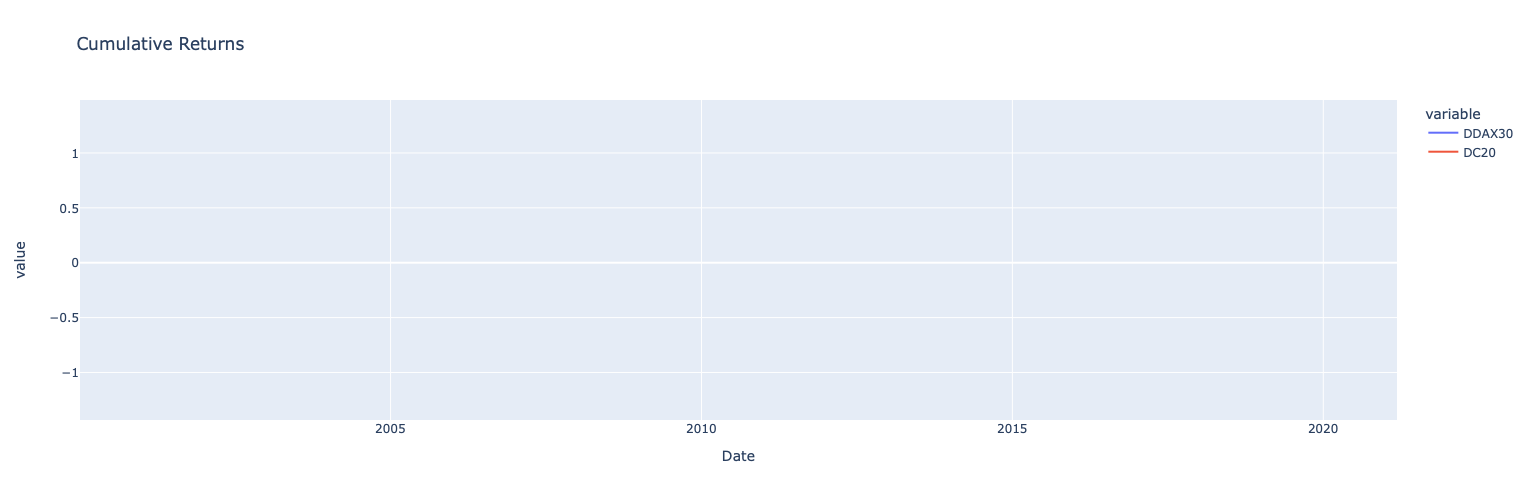

In [135]:
#Cumulative returns of DAX30 and C20
px.line(np.log((1+df.loc[:,'DDAX30':'DC20'].dropna()/100).cumprod()), title='Cumulative Returns', width=1000, height=500).show()

The highest cumulative return is obtained from investment in the portfolio consisting only of C20 index. The result is not surprising as a portfolio with higher risk would generally yield higher return. The lowest cumulative return is obtained from investment in the portfolio consisting of DAX30 index only. The other two lines for mixed portfolios mimic each other closely and lie in between C20 and DAX30 portfolio lines. 

### Calculating waights

Assuming that the investor is risk-averse and wants to minimize the variance of the portfolio, we can derive the first-order condition for the minimum-variance portfolio weights. The time-varying weights to DAX30 index in the minimum-variance portfolio:
$$\begin{aligned}
\bar{\sigma}_t^2=\vartheta_t^2\sigma_{1,t}^2+(1-\vartheta_t)^2\sigma_{2,t}^2+2\vartheta_t(1-\vartheta_t)\sigma_{12,t}
\end{aligned}
$$

$$\begin{aligned}
\frac{\partial\bar{\sigma}_t^2}{\partial\vartheta_t}=2\vartheta_t\sigma_{1,t}^2-2(1-\vartheta_t)\sigma_{2,t}^2+2\sigma_{12,t}-4\vartheta_t\sigma_{12,t}=0 \\
\end{aligned}
$$
$$
\begin{aligned}
\vartheta_t=\frac{\sigma_{2,t}^2-\sigma_{12,t}}{\sigma_{1,t}^2+\sigma_{2,t}^2-2\sigma_{12,t}}
\end{aligned}$$



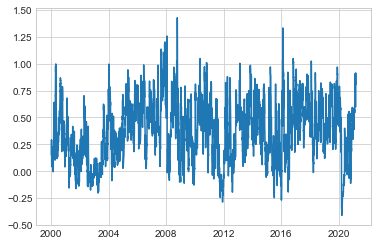

In [141]:
# calculates weights, just check
sigma_1 =garch_vol_df['DDAX30']
sigma_2 =garch_vol_df['DC20']
sigma_12 = (sigma_1 *sigma_2*dcc_corr['DAX30 - C20'])
weights = (sigma_2**2 - sigma_12)/(sigma_1**2 + sigma_2**2 - 2 * sigma_12)
plt.plot(weights);

Plot above shows optimal weights for DAX30 minimizing the risk

In [137]:
sigma_1 = sm.symbols('sigma_1')
sigma_2 = sm.symbols('sigma_2')
sigma_12 = sm.symbols('sigma_12')
vartheta = sm.symbols('vartheta')

In [138]:
f = vartheta**2 * sigma_1**2 + (1-vartheta)**2 * sigma_2**2 + 2*vartheta*(1-vartheta)*sigma_12
f

sigma_1**2*vartheta**2 + 2*sigma_12*vartheta*(1 - vartheta) + sigma_2**2*(1 - vartheta)**2

In [139]:
fnk = sm.lambdify((sigma_1,sigma_2,sigma_12,vartheta),f)
fnk

<function _lambdifygenerated(sigma_1, sigma_2, sigma_12, vartheta)>

In [145]:
# We can use sympy in order to find derivative 
sm.Derivative(f, vartheta,evaluate=True)

2*sigma_1**2*vartheta - 2*sigma_12*vartheta + 2*sigma_12*(1 - vartheta) + sigma_2**2*(2*vartheta - 2)

In [148]:
df['portfolio'] = weights*df['DDAX30'] + (1-weights)*df['DC20']

In [153]:
df.loc[:,['DDAX30','DC20','portfolio']].describe()

DDAX30        DC20   portfolio
count  5427.00000  5427.00000  5427.00000
mean      0.01401     0.03140     0.01754
std       1.48378     1.25768     1.18385
min     -13.05486   -11.72319    -7.67360
25%      -0.66006    -0.59107    -0.55313
50%       0.06539     0.05674     0.05820
75%       0.73933     0.69672     0.64501
max      10.79747     9.49635    10.61995

We can see that standard deviation for our portfolio is smaller

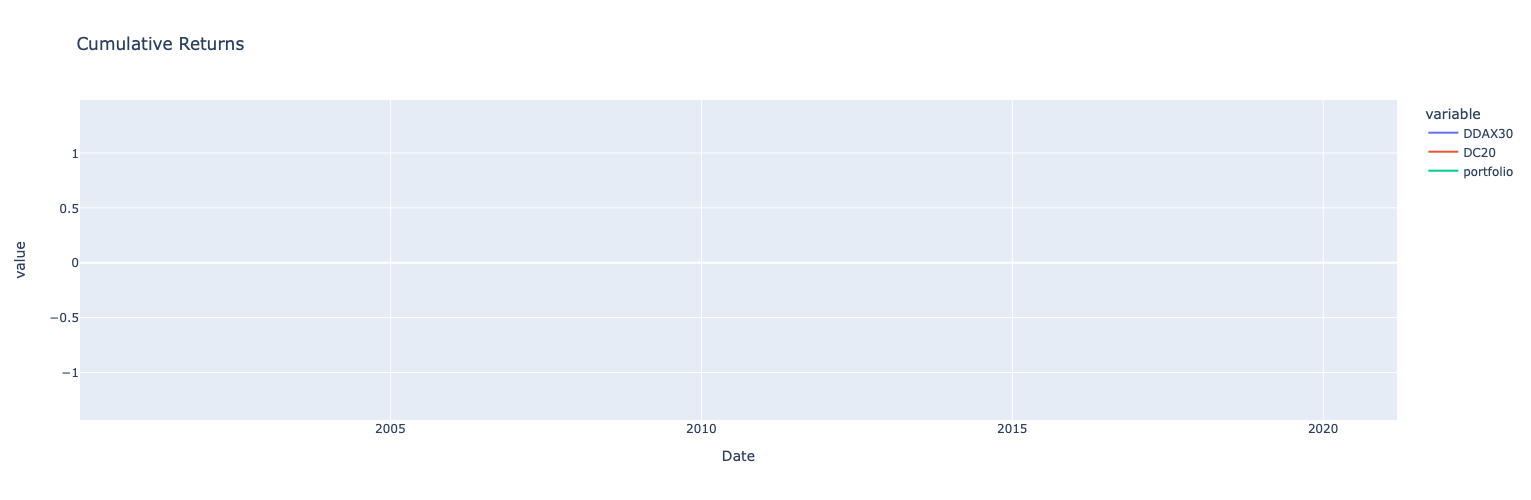

In [154]:
#Cumulative returns of DAX30 and C20
px.line(np.log((1+df.loc[:,['DDAX30','DC20','portfolio']].dropna()/100).cumprod()), title='Cumulative Returns', width=1000, height=500).show()

# Further analysis

Despite clear diversification benefits in terms of risk reduction, adding exposure to DAX30 index seems to be a bad idea only looking on returns. However, we could not expect another results, because we follow the minimum variance portfolio approach, meaning that an investor can choose portfolio weights, that  gives the  smallest possible variance. As an extensions of this thesis, one could follow the mean-variance approach, which is a good way to balance expected return against the associated risk, and obtain the gains from diversification. Another extension could be either choosing another index than DAX30 or including more indices at the same time. 

# Conclusion


Add concise conclusion. 

Through the DCC-GARCH modelling, there are evidences suggesting that portfolio diversification opportunities exist through the inclusion of DAX30 index into the portfolio consisting solely of C20 index. The correlation between these two assets is approximately 0.6.